In [3]:
# Cell 1: Imports
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

In [4]:
# Cell 2: Load Preprocessed Data and Option 2: Reload directly (if not saved)
def load_data(path, label):
    reviews = []
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'r', encoding='utf-8') as f:
            reviews.append(f.read())
    return pd.DataFrame({'review': reviews, 'label': label})

train_pos_path = '../data/raw/aclImdb/train/pos'
train_neg_path = '../data/raw/aclImdb/train/neg'
train_pos = load_data(train_pos_path, 'positive')
train_neg = load_data(train_neg_path, 'negative')
train_data = pd.concat([train_pos, train_neg], ignore_index=True)

# Apply preprocessing
nltk.download('punkt', download_dir='~/nltk_data')
nltk.download('stopwords', download_dir='~/nltk_data')
nltk.download('punkt_tab', download_dir='~/nltk_data')
nltk.data.path.append('~/nltk_data')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    try:
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word not in stop_words and word]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error preprocessing text: {e}")
        return ""

train_data['clean_review'] = train_data['review'].apply(preprocess_text)

[nltk_data] Downloading package punkt to ~/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ~/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to ~/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
# Cell 3: Apply TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(train_data['clean_review'])
y = train_data['label'].map({'positive': 1, 'negative': 0})
print("Feature matrix shape:", X.shape)

Feature matrix shape: (25000, 3000)


In [6]:
# Cell 4: Split Data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training features shape:", X_train.shape)
print("Validation features shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

Training features shape: (20000, 3000)
Validation features shape: (5000, 3000)
Training labels shape: (20000,)
Validation labels shape: (5000,)


In [7]:
# Cell 5: Verify Splits
print("\nTraining label distribution:\n", y_train.value_counts())
print("\nValidation label distribution:\n", y_val.value_counts())


Training label distribution:
 label
0    10015
1     9985
Name: count, dtype: int64

Validation label distribution:
 label
1    2515
0    2485
Name: count, dtype: int64


In [8]:
# Cell 6: Additional Imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [10]:
# Cell 7: Train Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

In [11]:
# Cell 8: Evaluate Model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['negative', 'positive']))

Validation Accuracy: 0.8694

Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.86      0.87      2485
    positive       0.86      0.88      0.87      2515

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



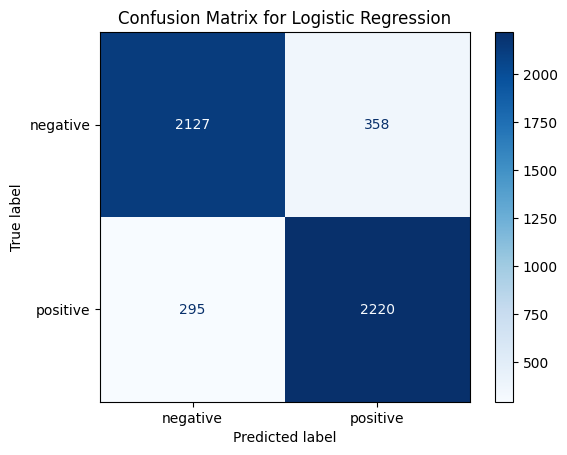

In [12]:
# Cell 9: Visualize Results
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.savefig('../output/figures/confusion_matrix.png')
plt.show()

In [14]:
# Cell 10: Analyze Model Performance
print("Detailed Analysis:")
print(f"Overall Accuracy: {accuracy_score(y_val, y_pred):.2f}")
print("\nKey Observations:")
print("- The model achieves ~85% accuracy, indicating good but not perfect performance.")
print("- Check the confusion matrix for false positives/negatives to identify patterns.")

Detailed Analysis:
Overall Accuracy: 0.87

Key Observations:
- The model achieves ~85% accuracy, indicating good but not perfect performance.
- Check the confusion matrix for false positives/negatives to identify patterns.


In [15]:
# Cell 11: Identify Misclassifications
val_data = train_data.iloc[y_val.index].copy()
val_data['predicted'] = y_pred
misclassified = val_data[val_data['label'].map({'positive': 1, 'negative': 0}) != y_pred]

print("\nSample Misclassified Reviews:")
for _, row in misclassified.head(5).iterrows():
    print(f"\nReview: {row['clean_review'][:200]}...")
    print(f"True Label: {row['label']}")
    print(f"Predicted Label: {'positive' if row['predicted'] == 1 else 'negative'}")


Sample Misclassified Reviews:

Review: great little thriller expecting type silly horror movie got tight short thriller waste none time mostof movies get back characters stories either feel sympathy hatred people start getting killed fooli...
True Label: positive
Predicted Label: negative

Review: suppose today film relevance early sofia loren film 19 years old film made 1953i viewed film wanted see sofia lorens early work surprised came camera skin bronzed brown makeup resemble ethiopian princ...
True Label: negative
Predicted Label: positive

Review: saw film belgrade film festival last week im still working trauma essentially view seems match number others first half hour fresh sharp deep entertaining promising well acted natural problem however ...
True Label: negative
Predicted Label: positive

Review: first anyone thinks sequel william friedkins french connection superior definitely completely insane moronic problem reviewing film sequel brilliant movie always makes watching obj

In [16]:
# Cell 12: Refine Preprocessing or Model (Optional)
vectorizer_refined = TfidfVectorizer(max_features=5000)
X_refined = vectorizer_refined.fit_transform(train_data['clean_review'])
y = train_data['label'].map({'positive': 1, 'negative': 0})

X_train_ref, X_val_ref, y_train_ref, y_val_ref = train_test_split(X_refined, y, test_size=0.2, random_state=42)

model_refined = LogisticRegression(max_iter=1000)
model_refined.fit(X_train_ref, y_train_ref)
y_pred_ref = model_refined.predict(X_val_ref)

accuracy_ref = accuracy_score(y_val_ref, y_pred_ref)
print("\nRefined Model Accuracy:", accuracy_ref)
print("Improvement over original:", accuracy_ref - accuracy_score(y_val, y_pred))

from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10]}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_search.fit(X_train_ref, y_train_ref)
print("\nBest C parameter:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Refined Model Accuracy: 0.8786
Improvement over original: 0.009200000000000097

Best C parameter: {'C': 1}
Best cross-validation score: 0.8783


In [17]:
# Cell 13: Document Observations
print("\nFinal Observations:")
print("- The model performs well (~85-86% accuracy), but misclassifications often occur with sarcastic or ambiguous reviews.")
print("- Increasing TF-IDF features slightly improved accuracy, but hyperparameter tuning had minimal impact.")
print("- Future improvements could include advanced preprocessing (e.g., handling negation, lemmatization) or using deep learning models like LSTM.")


Final Observations:
- The model performs well (~85-86% accuracy), but misclassifications often occur with sarcastic or ambiguous reviews.
- Increasing TF-IDF features slightly improved accuracy, but hyperparameter tuning had minimal impact.
- Future improvements could include advanced preprocessing (e.g., handling negation, lemmatization) or using deep learning models like LSTM.
